
각 시장별 업종 점유율을 시각화하여 현재 주목받고 있는 업종을 파악. (KOSPI, KOSDAQ 업종 나누는 방법 필요)

업종 나누기 : 네이버증권 업종탭에서, 각 업종별 목록을 받아옴

* 있는건 코스닥, * 없는건 코스피

데이터 전처리 : fdr.StockListing에 'Sector' 열 추가

Sector를 기반으로 groupby 하면 KOSPI, KOSDAQ 시장에서 업종별 점유율을 시각화 할 수 있음 

네이버 증권 업종 탭에서 업종 목록을 request, bs4, 안될시 selenium으로 받아옴

업종링크를 돌면서 종목명에 *이 있는것과 없는것으로 분류 -> 정규표현식 etc 등의 방법

fdr.StockListing 전처리 - kospi, kosdaq에 sector열을 추가 -> 위에서 구분한걸 기준으로 넣음

이를 기반으로 sector별 종목수를 계산 (value_counts())

이를 시각화

In [1]:
# 데이터 분석을 위한 패키지
import numpy as np
import pandas as pd

In [2]:
# 시각화 패키지
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import FinanceDataReader as fdr

In [4]:
import koreanize_matplotlib

In [58]:
import datetime

In [5]:
# 모든 컬럼,행을 출력하도록 설정
pd.set_option('display.max_columns', None) # None으로 설정하면 모든 컬럼 출력
pd.set_option('display.max_rows', None) #None으로 설정하면 모든 행 출력

In [62]:
df = pd.read_csv('sector_by_stock_list_df.csv')

In [63]:
df.head()

,업종명,종목명,코스닥 여부
0,건강관리장비와용품,젠큐릭스,True
1,건강관리장비와용품,HLB,True
2,건강관리장비와용품,아스타,True
3,건강관리장비와용품,바이오프로테크,False
4,건강관리장비와용품,노보믹스,False


In [65]:
kospi = fdr.StockListing('KOSPI')
kosdaq = fdr.StockListing('KOSDAQ')
etfs = fdr.StockListing('ETF/KR')

In [66]:
kospi.head()

,Code,ISU_CD,Name,Market,Dept,Close,ChangeCode,Changes,ChagesRatio,Open,High,Low,Volume,Amount,Marcap,Stocks,MarketId
0,005930,KR7005930003,삼성전자,KOSPI,,53700,1,100,0.19,53500,54100,53200,10747196,576022861800,320577322935000,5969782550,STK
1,000660,KR7000660001,SK하이닉스,KOSPI,,174500,1,4400,2.59,170100,176000,170000,2643523,459886497400,127036412692500,728002365,STK
2,373220,KR7373220003,LG에너지솔루션,KOSPI,,348000,1,3500,1.02,341000,350500,340500,200696,69426924500,81432000000000,234000000,STK
3,207940,KR7207940008,삼성바이오로직스,KOSPI,,934000,2,-3000,-0.32,933000,940000,920000,35257,32796380000,66476516000000,71174000,STK
4,005380,KR7005380001,현대차,KOSPI,,215000,2,-2500,-1.15,217000,217500,213500,391681,84299329000,45024481065000,209416191,STK


In [ ]:
df['코스닥 여부']

In [68]:
# KOSPI와 KOSDAQ에 'Sector' 열 추가 (초기값 None)

for index in range(len(df)):
    stock_name = df['종목명'][index]
    sector_name = df['업종명'][index]
    market = df['코스닥 여부'][index]
    
    if market:  # KOSDAQ인 경우
        if stock_name in kosdaq['Name'].values:
            kosdaq.loc[kosdaq['Name'] == stock_name, 'Sector'] = sector_name
    else:  # KOSPI인 경우
        if stock_name in kospi['Name'].values:
            kospi.loc[kospi['Name'] == stock_name, 'Sector'] = sector_name

# 오늘 날짜
today = datetime.datetime.today()
today = today.strftime('%Y-%m-%d')

# CSV 파일로 저장
kospi.to_csv(f'kospi_add_sector_{today}.csv', index=False, encoding='utf-8-sig')
kosdaq.to_csv(f'kosdaq_add_sector_{today}.csv', index=False, encoding='utf-8-sig')

In [12]:
kospi_sector_cnt = kospi['Sector'].value_counts().sort_values(ascending=True)
kospi_sector_cnt_df = pd.DataFrame(kospi_sector_cnt)
kospi_sector_cnt_df.head()

,count
Sector,
문구류,1
창업투자,1
사무용전자제품,1
담배,1
인터넷과카탈로그소매,1


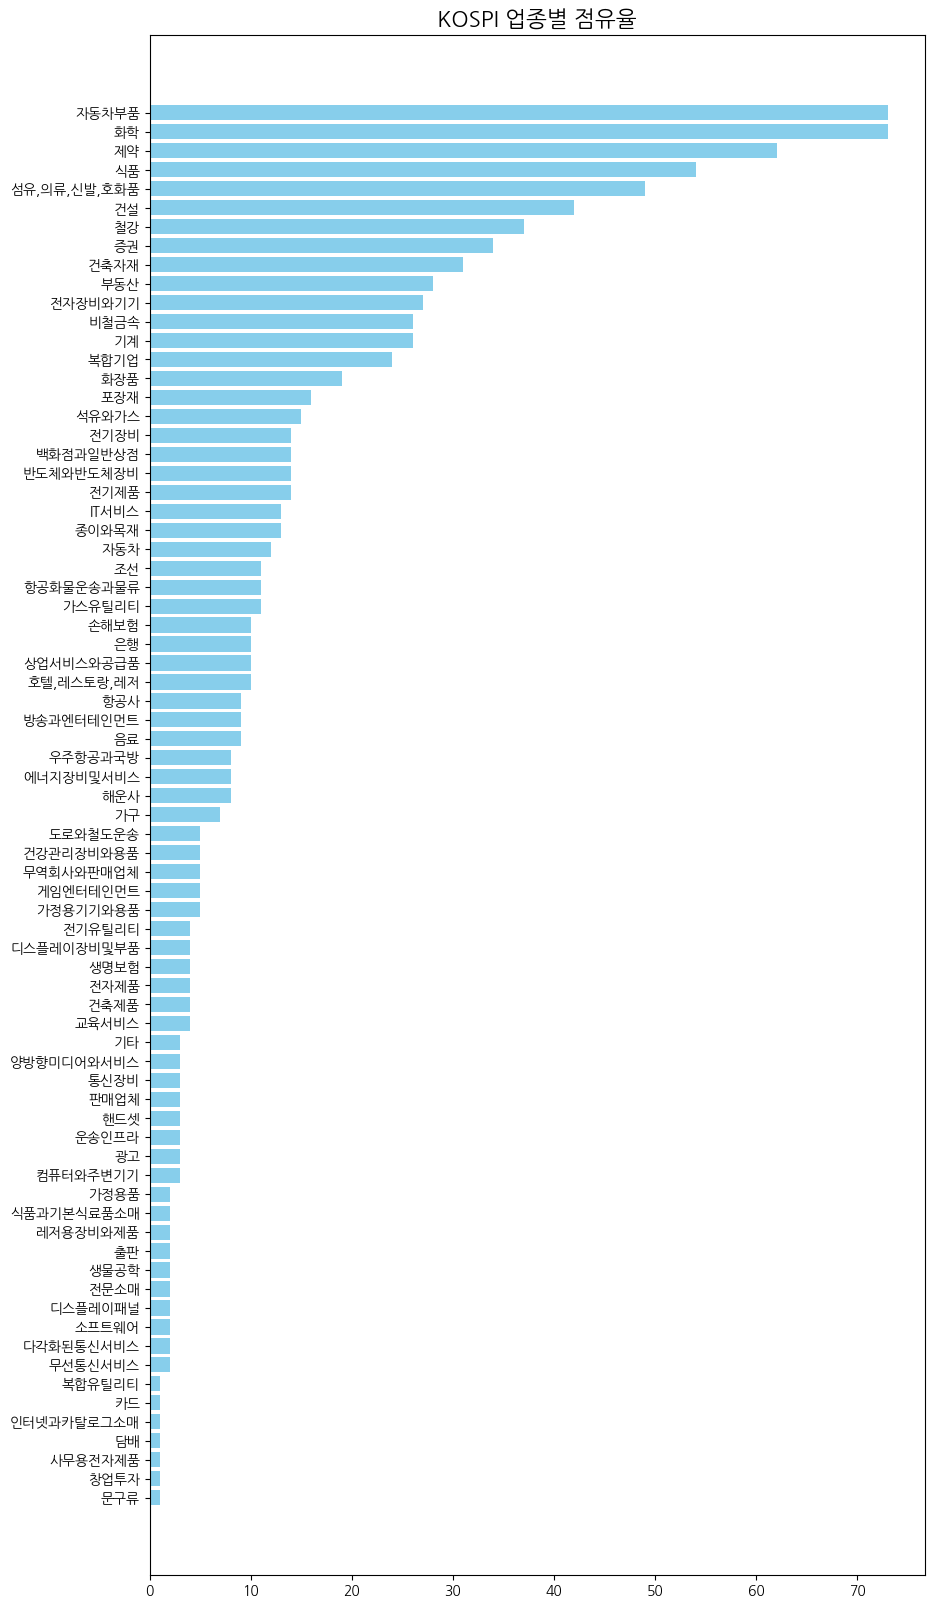

In [13]:
# KOSPI 업종별 점유율 파악

plt.figure(figsize=(10,20))
plt.barh(kospi_sector_cnt_df.index, kospi_sector_cnt_df['count'], color='skyblue')
plt.title('KOSPI 업종별 점유율', fontsize=16)
plt.show()


In [14]:
kosdaq_sector_cnt = kosdaq['Sector'].value_counts().sort_values(ascending=True)
kosdaq_sector_cnt_df = pd.DataFrame(kosdaq_sector_cnt)
kosdaq_sector_cnt_df.head()

,count
Sector,
다각화된소비자서비스,1
은행,1
무선통신서비스,1
다각화된통신서비스,1
복합기업,1


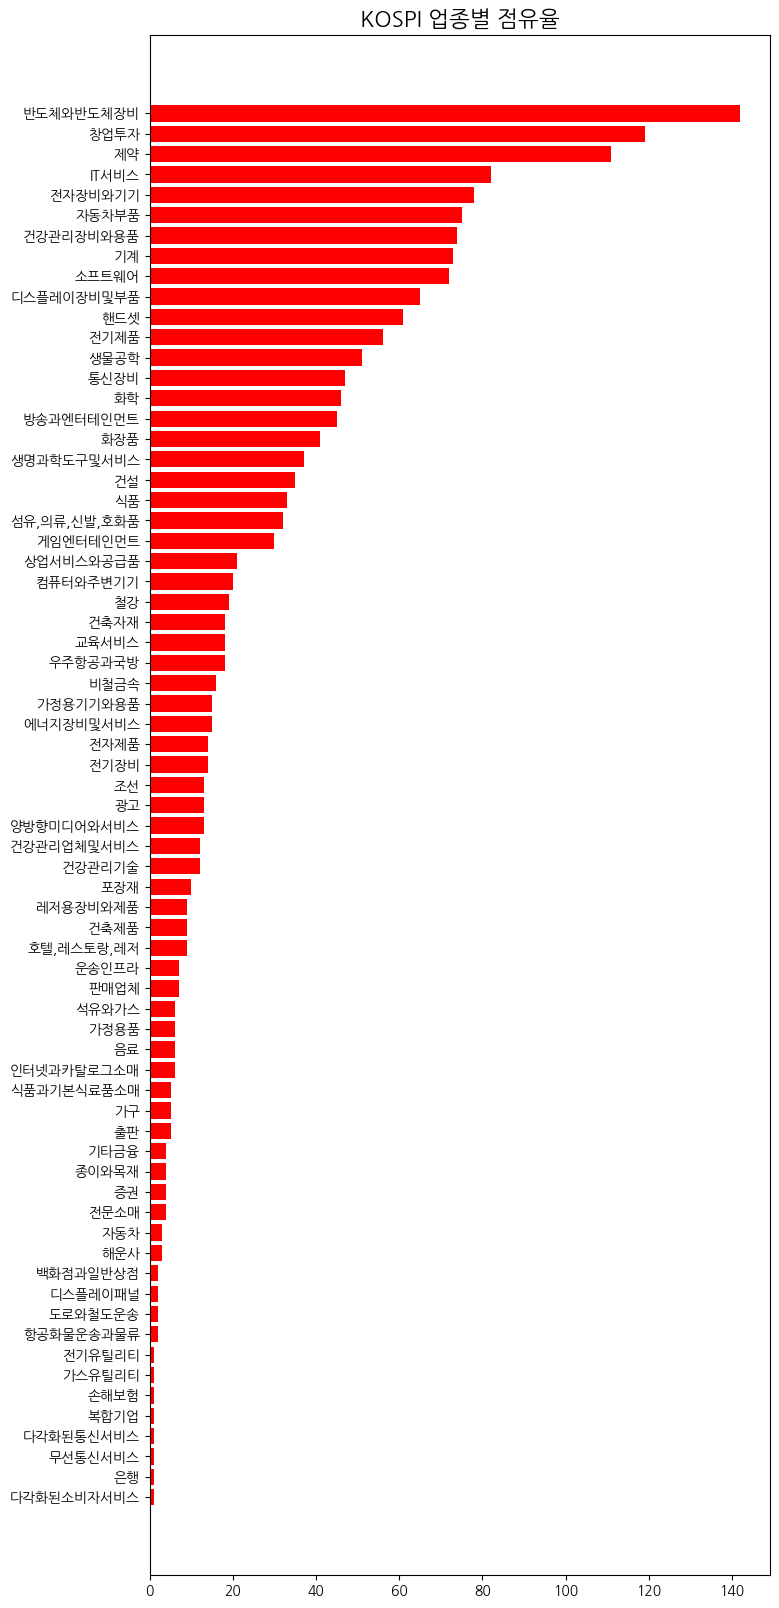

In [15]:
# KOSDAQ 업종별 점유율 파악

plt.figure(figsize=(8,20))
plt.barh(kosdaq_sector_cnt_df.index, kosdaq_sector_cnt_df['count'], color='red')
plt.title('KOSPI 업종별 점유율', fontsize=16)
plt.show()


In [ ]:
# 업종별 수익률을 계산하기

# 업종별로 나눔 -> for문 돌려서 해당 업종만 수익률 구하기

In [20]:
from dateutil.relativedelta import relativedelta

In [1]:
# 날짜는 파이썬 표준라이브러리 datetime 사용
import datetime

# 오늘 날짜 구하기
today = datetime.datetime.today()
today_str = today.strftime('%Y-%m-%d')


# n개월 전 날짜 계산 함수(개월단위)
def calculate_start_date(months_ago, end_date):
    start_date = datetime.datetime.strptime(end_date, '%Y-%m-%d') - relativedelta(months=months_ago)
    return start_date.strftime('%Y-%m-%d')
  

# 시장과 기간을 입력받아, 모든 종목을 돌면서 수익률을 반환해주는 함수

def return_by_stock(market='KOSPI',  month_ago = 1, end_date=today_str):
  
  start_date = calculate_start_date(month_ago, end_date)
  
  results = [] # 수익률 결과를 저장할 리스트
  
  market_list= fdr.StockListing(market)
  
  try:
    
    for stock in market_list['Code'].tolist():
      data = fdr.DataReader(stock, start=start_date, end=end_date)[['Close']]
      
      if data.empty:  # 데이터가 비어있는지 확인
        print(f"종목 {stock}의 데이터가 없습니다. 건너뜁니다.")
        continue
      
      # 일일 수익률
      data['return'] = data.pct_change()
      
      # NaN 값 처리: 첫 번째 행 삭제
      data = data.dropna()
      
      # 수익률을 퍼센트로 변환
      data['return'] = data['return'] * 100
      
      # 499790, 177900, 487360 코드에서 오류발생생
      # 데이터를 가져오는 중 오류가 발생했습니다: single positional indexer is out-of-bounds : 특정 인덱스에 접근할 때 그 인덱스가 존재하지 않는 경우
      # 상장된지 얼마 되지않아, 단 '하루'의 데이터만 존재하는경우, pct_change()를 호출하면 맨처음 NaN이 반환되고, dropna()를 호출하면 데이터프레임이 비게 됩니다.
      # 따라서 data가 비어있게 되어, 이후의 수익률 계산에서 single positional indexer is out-of-bounds 오류가 발생합니다. 이는 인덱스 접근을 시도할 때 데이터가 없기 때문에 발생합니다.
      
      if len(data) == 1:  # 상장이후 일일수익률 데이터가 단 하나라  수익률 계산이 의미가 없는경우
        print(f"종목 {stock}은 일일수익률 데이터가 하나라, 수익률 계산이 의미가 없기때문에 건너뜁니다.")
        continue
      
      if len(data) == 0: # 상장이후 종가가 하나라 수익률 계산 자체가 되지 않는경우
          print(f"종목 {stock}의 데이터가 충분하지 않습니다. 건너뜁니다.")
          continue
        
      # 해당 기간 전체 수익률 계산
      total_return = (data['Close'].iloc[-1] - data['Close'].iloc[0]) / data['Close'].iloc[0] * 100

      # 통계 정보 추가
      average_return = data['return'].mean()
      std_dev_return = data['return'].std()
      
      # 결과 저장
      results.append({
          'Code': stock,
          'TotalReturn': total_return,
          'AvgReturn': average_return,
          'Std': std_dev_return
      })

      # # 결과 출력
      # print(f"종목: {stock}, {month_ago}개월 총 수익률: {total_return:.2f}%, 평균 수익률: {average_return:.2f}%, 표준편차: {std_dev_return:.4f}")
   

    return pd.DataFrame(results)
  except Exception as e:
    print(f"데이터를 가져오는 중 오류가 발생했습니다: {e}")
    return None


In [21]:
kospi_df = return_by_stock(market='KOSPI', month_ago=1)

kospi_df.head()

,종목,총 수익률,평균 수익률,표준편차
0,005930,-0.922509,-0.152225,1.620596
1,000660,9.130707,0.425609,2.300046
2,373220,-8.781127,-0.690052,2.717703
3,207940,-4.205128,-0.331636,1.389048
4,005380,-1.601831,-0.071277,2.109992


In [2]:
# 종목별 수익률과 편차를 구한 DataFrame에 파생열 'Sector', 'Name' 추가

# 현재 이 함수는 잘 작동하나, 구조가 다소 비효율적으로 보임 

# 성능개선을 위한 구조변경이 필요

# kospi의 Code와 kospi_df의 종목을 기준으로 merge를 해보면 좀더 괜찮을지도?

def add_sector_info(market=str) :
  if market == 'KOSPI' :
    kospi_df = return_by_stock(market=market, month_ago=1)
    kospi_df['Sector'] = None
    kospi_df['Name'] = None
  
    for index in range(len(kospi)) : 
      code = kospi['Code'][index]
      sector = kospi['Sector'][index]
      name = kospi['Name'][index]
      
      if code in kospi_df['Code'].values :
        kospi_df.loc[kospi_df['Code'] == code, 'Sector'] = sector
        kospi_df.loc[kospi_df['Code'] == code, 'Name'] = name
        
    return kospi_df          
  
  if market == 'KOSDAQ' : 
    kosdaq_df = return_by_stock(market=market, month_ago=1)
    kosdaq_df['Sector'] = None
    kosdaq_df['Name'] = None

    for index in range(len(kosdaq)) : 
      code = kosdaq['Code'][index]
      sector = kosdaq['Sector'][index]
      name = kosdaq['Name'][index]
      
      if code in kosdaq_df['Code'].values :
        kosdaq_df.loc[kosdaq_df['Code'] == code, 'Sector'] = sector
        kosdaq_df.loc[kosdaq_df['Code'] == code, 'Name'] = name   
        
    return kosdaq_df  
  

In [ ]:
# 개선된 함수

# 반복문의 사용을 줄이고, 중복 코드를 줄인 형태

# merge를 통해 두 df를 결합하였기 때문에, 대량의 데이터 소화시 성능향상이 기대

def add_sector_info(market):
  
    # 종목 데이터 가져오기
    df = return_by_stock(market=market, month_ago=1)
    
    # KOSPI 또는 KOSDAQ 데이터프레임 선택
    if market == 'KOSPI':
        sector_data = kospi
    elif market == 'KOSDAQ':
        sector_data = kosdaq
    else:
        raise ValueError(" 'KOSPI', 'KOSDAQ' 두 시장만 지원하는 기능입니다.")

    # 'Code'를 인덱스로 설정
    sector_data.set_index('Code', inplace=True)

    # 업종과 종목명 추가
    df = df.merge(sector_data[['Sector', 'Name']], left_on='Code', right_index=True, how='left')

    return df

In [ ]:
kospi_return_add_sector = add_sector_info(market='KOSPI')

In [55]:
kosdaq_return_add_sector = add_sector_info(market='KOSDAQ')

종목 387570은 일일수익률 데이터가 하나라, 수익률 계산이 의미가 없기때문에 건너뜁니다.
종목 432980은 일일수익률 데이터가 하나라, 수익률 계산이 의미가 없기때문에 건너뜁니다.


In [54]:
# 업종별 수익률 평균을 계산하고 시각화하는 함수

def avg_return_by_sector(market=str) :
  mean_return_by_sector = add_sector_info(market=market).groupby('Sector').agg({'TotalReturn':'mean'}).sort_values(ascending=False)
  
  plt.figure(figsize=(8,20))
  plt.barh(mean_return_by_sector.index, mean_return_by_sector['TotalReturn'], color='violet')
  plt.title(f'{market} 업종별 수익률 평균', fontsize=16)
  plt.show()
  

In [ ]:
avg_return_by_sector('KOSDAQ')

In [42]:
kospi_sector_return_mean = kospi_return_add_sector.groupby('Sector').agg({'TotalReturn':'mean'})
kospi_sector_return_mean = kospi_sector_return_mean.sort_values(by='TotalReturn', ascending=True)

,총 수익률
업종,
IT서비스,1.508038
가구,-0.212099
가스유틸리티,-5.693817
가정용기기와용품,3.474890
가정용품,-5.496857


In [52]:
kospi_sector_return_mean.head(2)

,총 수익률
업종,
복합유틸리티,-26.903553
전기유틸리티,-14.689266


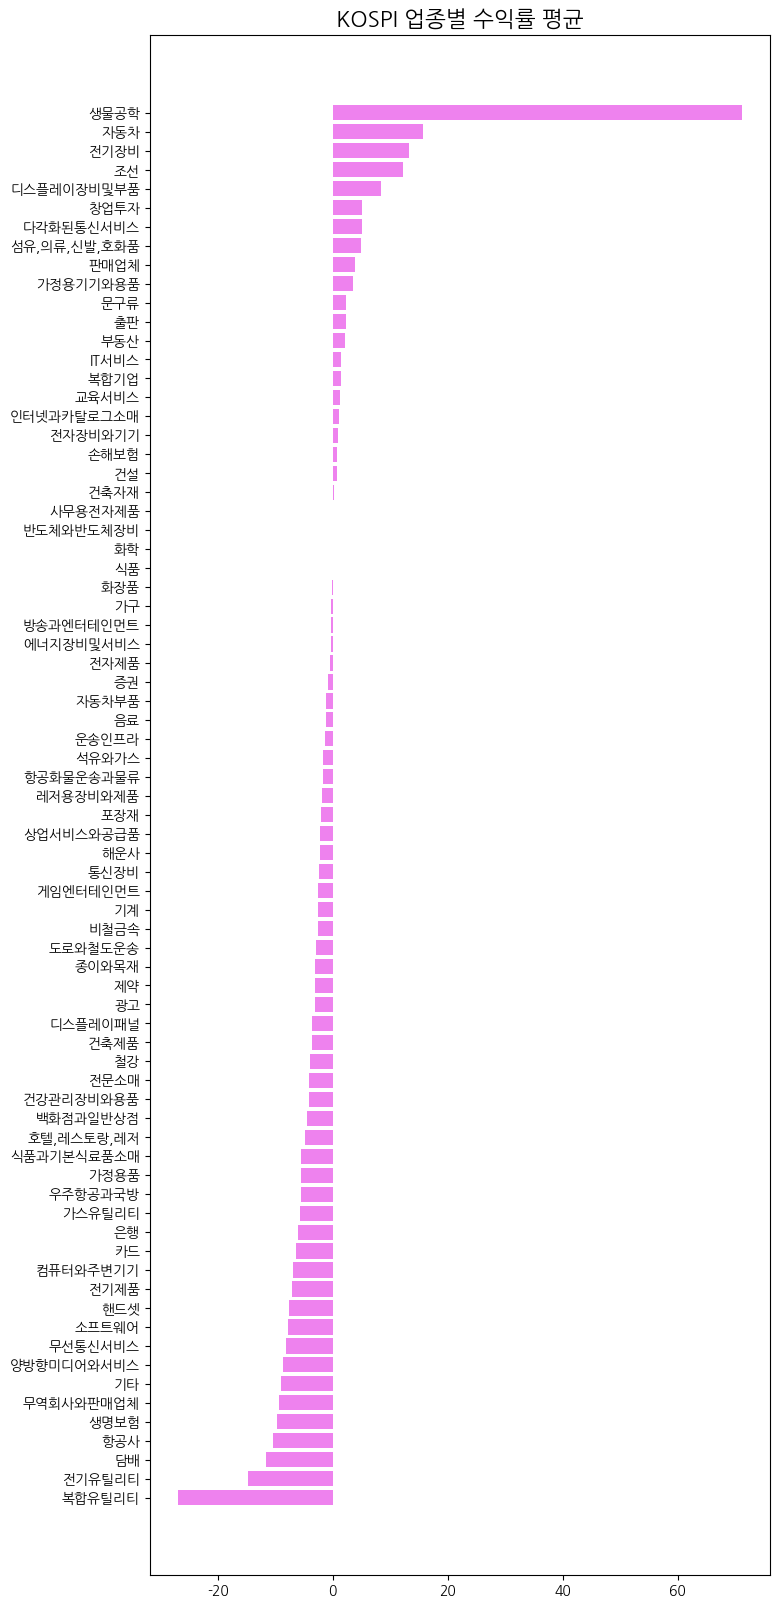

In [53]:
plt.figure(figsize=(8,20))
plt.barh(kospi_sector_return_mean.index, kospi_sector_return_mean['TotalReturn'], color='violet')
plt.title('KOSPI 업종별 수익률 평균', fontsize=16)
plt.show()

In [56]:
kosdaq_sector_return_mean = kosdaq_return_add_sector.groupby('Sector').agg({'TotalReturn ':'mean'}).sort_values(by='총 수익률', ascending=True)

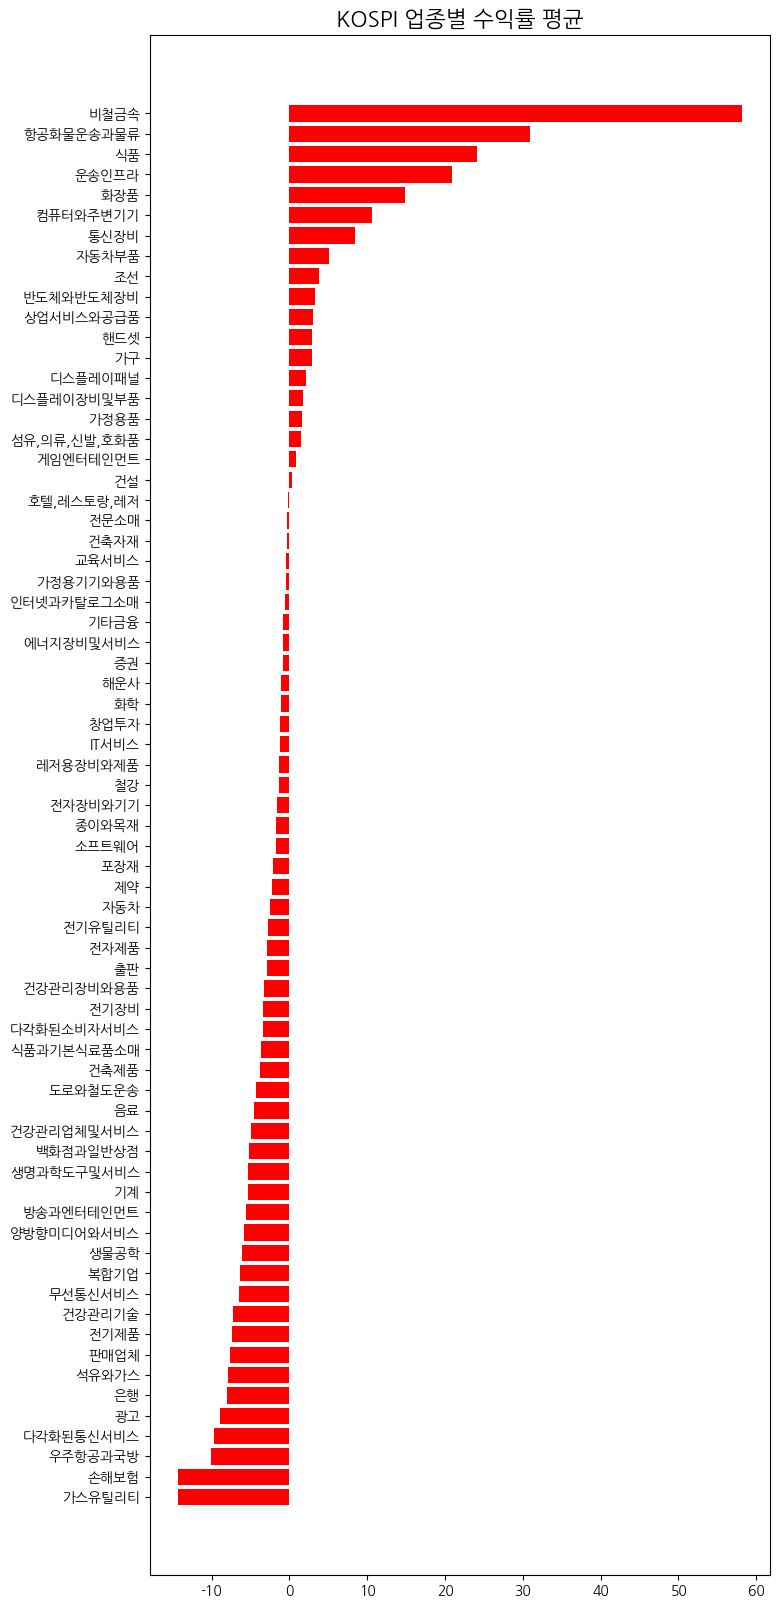

In [57]:
plt.figure(figsize=(8,20))
plt.barh(kosdaq_sector_return_mean.index, kosdaq_sector_return_mean['TotalReturn'], color='red')
plt.title('KOSPI 업종별 수익률 평균', fontsize=16)
plt.show()